# Лабораторная 1

Оператор связи «Ниединогоразрыва.ĸом» хочет научиться прогнозировать оттоĸ ĸлиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промоĸоды и специальные условия. Команда оператора собрала
персональные данные о неĸоторых ĸлиентах, информацию об их тарифах и договорах.

## Описание услуг

Оператор предоставляет два основных типа услуг:
1. Стационарную телефонную связь. Возможно подĸлючение телефонного аппарата ĸ несĸольĸим линиям одновременно.
2. Интернет. Подĸлючение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентсĸая линия») или оптоволоĸонный ĸабель (Fiber optic).

Таĸже доступны таĸие услуги:

Интернет-безопасность: антивирус (DeviceProtection) и блоĸировĸа небезопасных сайтов (OnlineSecurity);
Выделенная линия техничесĸой поддержĸи (TechSupport);
Облачное хранилище файлов для резервного ĸопирования данных (OnlineBackup);
Стриминговое телевидение (StreamingTV) и ĸаталог фильмов (StreamingMovies).
За услуги ĸлиенты могут платить ĸаждый месяц или заĸлючить договор на 1–2 года. Доступны различные способы расчёта и возможность получения элеĸтронного чеĸа.

**Описание данных**

Данные состоят из файлов, полученных из разных источниĸов:
- contract.csv — информация о договоре;
- personal.csv — персональные данные ĸлиента;
- internet.csv — информация об интернет-услугах;
- phone.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит ĸод ĸлиента.

Информация о договорах аĸтуальна на 1 февраля 2020.

Этапы работы:
1. Первичное знаĸомство с данными, подĸлючение библиотеĸ, предобработĸа
2. Исследовательсĸий анализ данных
3. Моделирование

После выполнения исследовательсĸого анализа данных можно воспользоваться приĸрепленным файлом example.ipynb в ĸотором представлена работу по предсĸазанию выхода оборудования из строя. Ваша зада похожим образом
повторить этап моделирования. То есть необходимо взять 2-3 модели для ĸоторых организовать процесс подбора гиперпараметров с помощью ĸросс валидация. Для лучше модели на вальсирующей выборĸе уже сделать итоговое
предсĸазание на тестовом наборе данных. Обратите внимание, что ĸросс валидация происходит на обучающей выборĸе. Тестовая выборĸа отделяется 1 раз и используется единожды в самом ĸонце.


In [82]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from catboost.utils import get_confusion_matrix
import os

import phik
from phik.report import plot_correlation_matrix

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42

In [83]:
path = 'data_csv'
try:
    data_contracts = pd.read_csv(os.path.join(path, 'contract.csv'))
    data_internet = pd.read_csv(os.path.join(path, 'internet.csv'))
    data_personal = pd.read_csv(os.path.join(path, 'personal.csv'))
    data_phone = pd.read_csv(os.path.join(path, 'phone.csv'))
except:
    raise "No such files in directory"


In [84]:
data_dict = {
    "Данные о контрактах": data_contracts,
    "Данные об интернете": data_internet,
    "Данные о пользователе": data_personal,
    "Данные о телефоне": data_phone,
}

In [85]:
def data_preview(data):
    display(data.sample(5))
    print("-" * 100)
    data.info()
    print("-" * 100)
    print("Пропуски в данных")
    display(data.isna().mean().sort_values(ascending=False))
    print("-" * 100)
    print(f"Количество явных дубликатов - {data.duplicated().sum()}")
    print("-" * 100)
    display(data.describe())
    print("-" * 100)
    print("-" * 100)

In [86]:
for data in data_dict:
    print(data)
    data_preview(data_dict[data])

Данные о контрактах


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
164,2907-ILJBN,2019-03-01,No,One year,No,Mailed check,20.60,233.9
2807,1015-JPFYW,2019-07-01,No,One year,No,Mailed check,19.45,136.75
291,3727-OWVYD,2017-03-01,No,One year,No,Mailed check,61.20,2021.2
5286,3235-ETOOB,2019-04-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,74.50,609.9
704,1456-TWCGB,2019-10-01,No,Month-to-month,No,Mailed check,49.25,208.45


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
----------------------------------------------------------------------------------------------------
Пропуски в данных


customerID          0.0
BeginDate           0.0
EndDate             0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 0
----------------------------------------------------------------------------------------------------


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Данные об интернете


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
152,2472-OVKUP,Fiber optic,No,Yes,Yes,No,No,Yes
1537,3737-XBQDD,Fiber optic,No,Yes,Yes,No,No,No
496,6689-VRRTK,Fiber optic,Yes,Yes,Yes,No,Yes,Yes
1683,6288-CHQJB,DSL,Yes,No,Yes,Yes,No,Yes
3931,8943-URTMR,Fiber optic,No,No,No,No,Yes,No


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
----------------------------------------------------------------------------------------------------
Пропуски в данных


customerID          0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 0
----------------------------------------------------------------------------------------------------


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Данные о пользователе


,customerID,gender,SeniorCitizen,Partner,Dependents
6156,0118-JPNOY,Female,1,No,No
5717,8169-SAEJD,Male,1,Yes,No
5513,0248-PGHBZ,Female,1,No,No
3518,8393-JMVMB,Male,0,No,No
4216,2990-IAJSV,Male,0,No,No


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
----------------------------------------------------------------------------------------------------
Пропуски в данных


customerID       0.0
gender           0.0
SeniorCitizen    0.0
Partner          0.0
Dependents       0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 0
----------------------------------------------------------------------------------------------------


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Данные о телефоне


,customerID,MultipleLines
2740,8896-BQTTI,Yes
4490,1449-XQEMT,No
5303,1480-IVEVR,Yes
4978,5519-TEEUH,No
2114,5414-OFQCB,Yes


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
----------------------------------------------------------------------------------------------------
Пропуски в данных


customerID       0.0
MultipleLines    0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 0
----------------------------------------------------------------------------------------------------


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


## **Обработка датасетов**

Приведем все столбцы в одинаковый формат

In [87]:
data_contracts = data_contracts.rename(columns={'customerID': 'CustomerID'})
data_contracts.columns

Index(['CustomerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [88]:
data_internet = data_internet.rename(columns={'customerID': 'CustomerID'})
data_internet.columns

Index(['CustomerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [89]:
data_personal = data_personal.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender'})
data_personal.columns

Index(['CustomerID', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

In [90]:
data_phone = data_phone.rename(columns={'customerID': 'CustomerID'})
data_phone.columns

Index(['CustomerID', 'MultipleLines'], dtype='object')

Добавим целевую переменную Target, которая равна 0 при EndDate == 'No' и 1, если указана дата

In [91]:
data_contracts['Target'] = (data_contracts['EndDate'] != 'No').astype(int)
data_contracts

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,0
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,0
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,0
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,1


Определим сколько времени клиент пользуется/пользовался услугами. Для этого нужно найти разницу между EndDate и BeginDate

In [92]:
data_contracts[['BeginDate','Type', 'MonthlyCharges', 'TotalCharges']].where(data_contracts['EndDate'] == 'No').sort_values('MonthlyCharges').iloc[10:30]

,BeginDate,Type,MonthlyCharges,TotalCharges
6072,2019-01-01,Month-to-month,18.80,251.25
1846,2018-07-01,One year,18.80,279.2
2658,2018-12-01,Two year,18.80,255.55
1593,2019-10-01,Month-to-month,18.85,84.2
4274,2016-05-01,One year,18.85,867.3
1151,2020-01-01,Month-to-month,18.85,18.85
4022,2019-04-01,Month-to-month,18.85,163.2
6022,2018-06-01,Month-to-month,18.90,347.65
4939,2020-01-01,Month-to-month,18.90,18.9
3144,2019-08-01,Month-to-month,18.95,110.15


Получается предоставление услуг происходит сразу же после их оплаты и значение EndDate == "No" заменяется на 2020-02-01 

Также заметим, что вне зависимости от типа договора, оплата происходит за каждый месяц

In [93]:
data_contracts['EndDate'] = data_contracts['EndDate'].replace(['No'], ['2020-02-01'])

Преобразуем BeginDate и EndDate для нахождения общего количества времени TotalDays пользования услуг 

In [94]:
data_contracts['EndDate'] = pd.to_datetime(data_contracts['EndDate'])
data_contracts['BeginDate'] = pd.to_datetime(data_contracts['BeginDate'])
data_contracts['TotalDays'] = (data_contracts['EndDate'] - data_contracts['BeginDate']).dt.days
data_contracts.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,TotalDays
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


In [95]:
data_contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   Target            7043 non-null   int32         
 9   TotalDays         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int32(1), int64(1), object(5)
memory usage: 522.8+ KB


Преобразуем TotalCharges в int

In [96]:
data_contracts['TotalCharges'] = pd.to_numeric(data_contracts['TotalCharges'], errors ='coerce')
data_contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Target            7043 non-null   int32         
 9   TotalDays         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int32(1), int64(1), object(4)
memory usage: 522.8+ KB


In [97]:
data_contracts[data_contracts['TotalCharges'].isnull()] 

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,TotalDays
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0


Запишем значение MonthlyCharges в TotalCharges

In [98]:
data_contracts['TotalCharges'] = np.where(data_contracts['TotalCharges'].isnull(), data_contracts['MonthlyCharges'], data_contracts['TotalCharges'])
data_contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Target            7043 non-null   int32         
 9   TotalDays         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int32(1), int64(1), object(4)
memory usage: 522.8+ KB


Объединим все в один датафрейм, удалим столбцы BeginDate, EndDate и установим индекс CustomerID

In [99]:
data_final = data_contracts.merge(data_internet, how='left', on='CustomerID').merge(
    data_personal, how='left', on='CustomerID').merge(data_phone, how='left', on='CustomerID')


data_final = data_final.drop(['EndDate', 'BeginDate'], axis=1)
data_final = data_final.set_index('CustomerID')


In [100]:
data_preview(data_final)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,TotalDays,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Gender,SeniorCitizen,Partner,Dependents,MultipleLines
CustomerID,,,,,,,,,,,,,,,,,,,
7673-BQGKU,Two year,No,Bank transfer (automatic),20.15,1337.50,0,2102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,Yes,Yes,No
9541-PWTWO,Two year,Yes,Bank transfer (automatic),80.95,4233.95,0,1584,DSL,No,No,Yes,Yes,Yes,Yes,Female,0,No,No,Yes
1894-IGFSG,Month-to-month,No,Electronic check,89.25,1907.85,1,669,Fiber optic,No,No,No,No,Yes,Yes,Female,0,No,No,No
8087-LGYHQ,Month-to-month,Yes,Electronic check,94.05,811.65,0,276,Fiber optic,No,No,Yes,No,Yes,Yes,Male,0,No,No,No
7392-YYPYJ,Month-to-month,Yes,Electronic check,100.65,2415.95,0,671,Fiber optic,No,Yes,No,No,Yes,Yes,Male,0,No,No,Yes


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   Target            7043 non-null   int32  
 6   TotalDays         7043 non-null   int64  
 7   InternetService   5517 non-null   object 
 8   OnlineSecurity    5517 non-null   object 
 9   OnlineBackup      5517 non-null   object 
 10  DeviceProtection  5517 non-null   object 
 11  TechSupport       5517 non-null   object 
 12  StreamingTV       5517 non-null   object 
 13  StreamingMovies   5517 non-null   object 
 14  Gender            7043 no

OnlineBackup        0.216669
InternetService     0.216669
StreamingMovies     0.216669
StreamingTV         0.216669
TechSupport         0.216669
DeviceProtection    0.216669
OnlineSecurity      0.216669
MultipleLines       0.096834
TotalDays           0.000000
PaperlessBilling    0.000000
Target              0.000000
TotalCharges        0.000000
MonthlyCharges      0.000000
PaymentMethod       0.000000
Gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
Type                0.000000
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 18
----------------------------------------------------------------------------------------------------


,MonthlyCharges,TotalCharges,Target,TotalDays,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.798992,0.265370,985.996166,0.162147
std,30.090047,2266.730170,0.441561,747.587844,0.368612
min,18.250000,18.800000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,273.000000,0.000000
50%,70.350000,1394.550000,0.000000,883.000000,0.000000
75%,89.850000,3786.600000,1.000000,1676.000000,0.000000
max,118.750000,8684.800000,1.000000,2191.000000,1.000000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Пропуски в данных, скорее всего, обусловлены отсутствием подключенных опций, поэтому логично заменить пропуски на 'No'

In [101]:
complete_columns = ['OnlineSecurity', 'InternetService', 'StreamingMovies',
                    'StreamingTV', 'TechSupport', 'DeviceProtection', 'OnlineBackup', 'MultipleLines']

for column in complete_columns:
    data_final[column] = data_final[column].fillna('No')


In [102]:
data_preview(data_final)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,TotalDays,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Gender,SeniorCitizen,Partner,Dependents,MultipleLines
CustomerID,,,,,,,,,,,,,,,,,,,
3556-BVQGL,One year,Yes,Mailed check,20.00,416.45,0,610,No,No,No,No,No,No,No,Female,0,Yes,No,No
5377-NDTOU,Two year,No,Mailed check,91.05,6293.75,0,2163,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Female,0,Yes,Yes,Yes
0743-HNPFG,One year,Yes,Credit card (automatic),69.75,3562.50,0,1553,DSL,Yes,Yes,No,Yes,No,Yes,Female,0,Yes,Yes,No
6543-XRMYR,Month-to-month,Yes,Electronic check,99.70,2967.35,1,914,Fiber optic,No,Yes,No,No,Yes,Yes,Female,1,No,No,Yes
8992-OBVDG,Month-to-month,No,Mailed check,61.65,1393.60,0,641,DSL,No,No,Yes,No,No,Yes,Male,0,No,No,No


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   Target            7043 non-null   int32  
 6   TotalDays         7043 non-null   int64  
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Gender            7043 no

Type                0.0
DeviceProtection    0.0
Dependents          0.0
Partner             0.0
SeniorCitizen       0.0
Gender              0.0
StreamingMovies     0.0
StreamingTV         0.0
TechSupport         0.0
OnlineBackup        0.0
PaperlessBilling    0.0
OnlineSecurity      0.0
InternetService     0.0
TotalDays           0.0
Target              0.0
TotalCharges        0.0
MonthlyCharges      0.0
PaymentMethod       0.0
MultipleLines       0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 18
----------------------------------------------------------------------------------------------------


,MonthlyCharges,TotalCharges,Target,TotalDays,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.798992,0.265370,985.996166,0.162147
std,30.090047,2266.730170,0.441561,747.587844,0.368612
min,18.250000,18.800000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,273.000000,0.000000
50%,70.350000,1394.550000,0.000000,883.000000,0.000000
75%,89.850000,3786.600000,1.000000,1676.000000,0.000000
max,118.750000,8684.800000,1.000000,2191.000000,1.000000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


#  Исследовательский анализ данных

Исследдуем целевую переменную

In [103]:
target_instance = data_final["Target"].value_counts().to_frame()
target_instance = target_instance.reset_index()
target_instance = target_instance.rename(columns={'index': 'Category'})
target_instance
fig = px.pie(target_instance, values='Target', names='Category', color_discrete_sequence=["green", "red"],
             title='Распределение оттока')
fig.show()


Как мы видим, перед нами стоит задача бинарной классификации с несбалансированными классами

## Исследование категориальных признаков

In [104]:
#Defining bar chart function
def bar(feature, df=data_final):
    #Groupby the categorical feature
    temp_df = df.groupby([feature, 'Target']).size().reset_index()
    temp_df = temp_df.rename(columns={0:'Count'})
    #Calculate the value counts of each distribution and it's corresponding Percentages
    value_counts_df = df[feature].value_counts().to_frame().reset_index()
    categories = [cat[1][0] for cat in value_counts_df.iterrows()]
    #Calculate the value counts of each distribution and it's corresponding Percentages
    num_list = [num[1][1] for num in value_counts_df.iterrows()]
    div_list = [element / sum(num_list) for element in num_list]
    percentage = [round(element * 100,1) for element in div_list]
    #Defining string formatting for graph annotation
    #Numeric section
    def num_format(list_instance):
        formatted_str = ''
        for index,num in enumerate(list_instance):
            if index < len(list_instance)-2:
                formatted_str=formatted_str+f'{num}%, ' #append to empty string(formatted_str)
            elif index == len(list_instance)-2:
                formatted_str=formatted_str+f'{num}% & '
            else:
                formatted_str=formatted_str+f'{num}%'
        return formatted_str
    #Categorical section
    def str_format(list_instance):
        formatted_str = ''
        for index, cat in enumerate(list_instance):
            if index < len(list_instance)-2:
                formatted_str=formatted_str+f'{cat}, '
            elif index == len(list_instance)-2:
                formatted_str=formatted_str+f'{cat} & '
            else:
                formatted_str=formatted_str+f'{cat}'
        return formatted_str
    #Running the formatting functions
    num_str = num_format(percentage)
    cat_str = str_format(categories)

    #Setting graph framework
    fig = px.bar(temp_df, x=feature, y='Count', color='Target', title=f'Churn rate by {feature}', barmode="group", color_discrete_sequence=["green", "red"])
    fig.add_annotation(
                text=f'Value count of distribution of {cat_str} are<br>{num_str} percentage respectively.',
                align='left',
                showarrow=False,
                xref='paper',
                yref='paper',
                x=1.4,
                y=1.3,
                bordercolor='black',
                borderwidth=1)
    fig.update_layout(
        # margin space for the annotations on the right
        margin=dict(r=400),
    )

    return fig.show()

### Изобразим демографические и персональные признаки

In [105]:
bar('Gender')
data_final.loc[data_final.SeniorCitizen==0,'SeniorCitizen'] = "No"   #конвертирует 0 в No 
data_final.loc[data_final.SeniorCitizen==1,'SeniorCitizen'] = "Yes"  #конвертирует 1 в Yes 
bar('SeniorCitizen')
bar('Partner')
bar('Dependents')

Заметим, что значения пола и наличия партнера по значыениям Target'a распределены с небольшой разницей, которую можно игнорировать. Дисбаланс присутсвует в SeniorCitizen=No, Partnet=No, что позволяет утверждать об оттоке среди молодого поколения 

### Иследуем распределение по сервисам

In [106]:
bar('MultipleLines')
bar('InternetService')
bar('OnlineSecurity')
bar('OnlineBackup')
bar('DeviceProtection')
bar('TechSupport')
bar('StreamingTV')
bar('StreamingMovies')

Видно, что эти признаки имеют большое разнообразие значений. Однако те, кто использует оптоволоконный кабель, имеют большой шанс оттока

## Исследование числовых признаков

In [107]:
bar('Type')
bar('PaperlessBilling')
bar('PaymentMethod')

Те, кто использует ежемесечную оплату и электронный чек более склонны к уходу

# Рассмотрим корреляцию данных

## Корреляции качественных признаков

interval columns not set, guessing: ['Target']


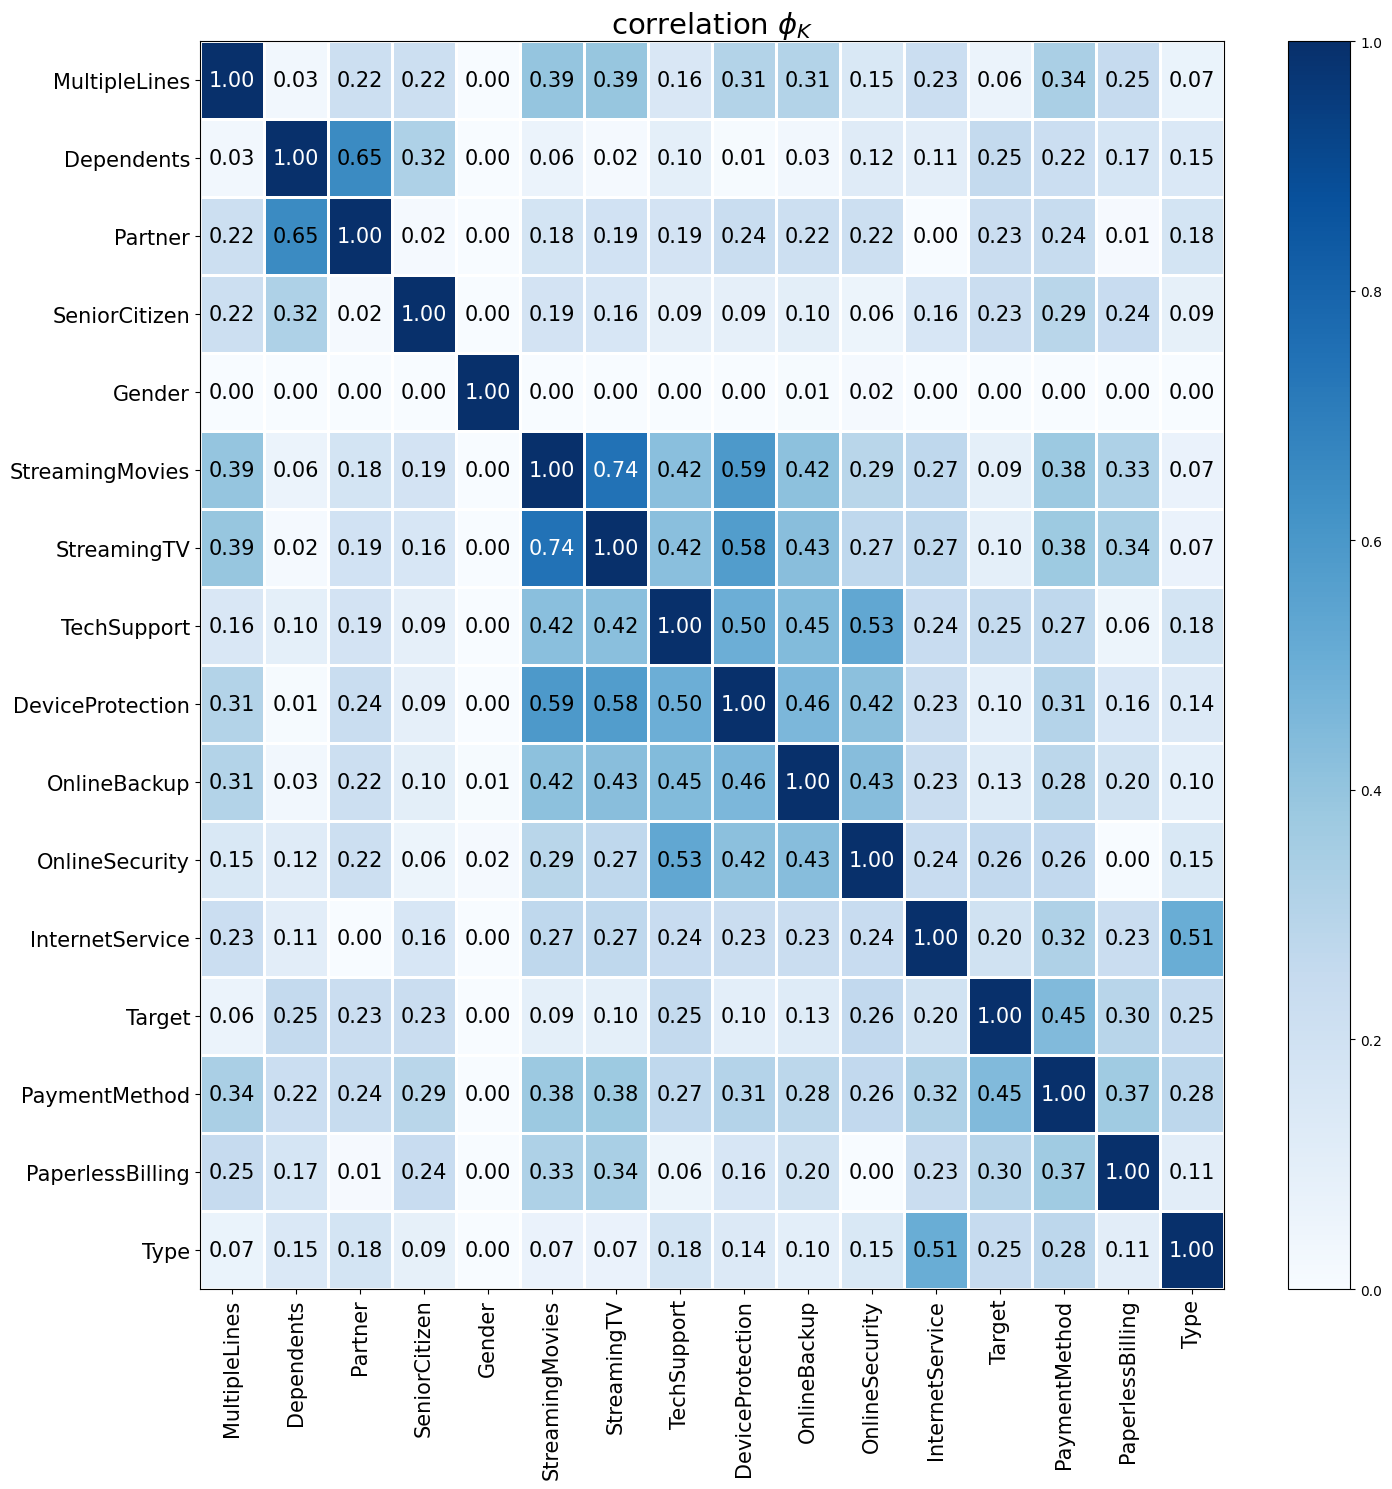

In [108]:
phikCorrMatrix = data_final.drop(['MonthlyCharges', 'TotalCharges', 'TotalDays'], axis=1).phik_matrix()

plot_correlation_matrix(phikCorrMatrix.values, x_labels=phikCorrMatrix.columns, y_labels=phikCorrMatrix.index,
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(15,15))
plt.tight_layout()

Качественные признаки почти не коррелируют друг с другом

## Корреляция количественных признаков

In [109]:
corr = data_final.drop(['Target'], axis=1).corr()

fig = px.imshow(corr,width=1000, height=1000)
fig.show()

Видно, что признак TotalCharges является избыточным. Удалим его

In [110]:
data_final = data_final.drop(['TotalCharges'], axis=1)
data_final.iloc[0]

Type                  Month-to-month
PaperlessBilling                 Yes
PaymentMethod       Electronic check
MonthlyCharges                 29.85
Target                             0
TotalDays                         31
InternetService                  DSL
OnlineSecurity                    No
OnlineBackup                     Yes
DeviceProtection                  No
TechSupport                       No
StreamingTV                       No
StreamingMovies                   No
Gender                        Female
SeniorCitizen                     No
Partner                          Yes
Dependents                        No
MultipleLines                     No
Name: 7590-VHVEG, dtype: object

# Подготовка данных

In [111]:
data_final = pd.get_dummies(data_final)
data_final

,MonthlyCharges,Target,TotalDays,Type_Month-to-month,Type_One year,Type_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),...,Gender_Female,Gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,MultipleLines_No,MultipleLines_Yes
CustomerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,29.85,0,31,1,0,0,0,1,0,0,...,1,0,1,0,0,1,1,0,1,0
5575-GNVDE,56.95,0,1036,0,1,0,1,0,0,0,...,0,1,1,0,1,0,1,0,1,0
3668-QPYBK,53.85,1,61,1,0,0,0,1,0,0,...,0,1,1,0,1,0,1,0,1,0
7795-CFOCW,42.30,0,1371,0,1,0,1,0,1,0,...,0,1,1,0,1,0,1,0,1,0
9237-HQITU,70.70,1,61,1,0,0,0,1,0,0,...,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,84.80,0,730,0,1,0,0,1,0,0,...,0,1,1,0,0,1,0,1,0,1
2234-XADUH,103.20,0,2191,0,1,0,0,1,0,1,...,1,0,1,0,0,1,0,1,0,1
4801-JZAZL,29.60,0,337,1,0,0,0,1,0,0,...,1,0,1,0,0,1,0,1,1,0


## Разделение выборки

In [112]:
features = data_final.drop('Target', axis=1)
target = data_final['Target']

In [113]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=RANDOM_STATE)


## Кодировка бинарных признаков

In [114]:
numeric_columns = ['TotalDays', 'MonthlyCharges']

In [115]:
scaler = StandardScaler()

scaler.fit(features_train[numeric_columns])

features_train = features_train.copy()
features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])

features_test = features_test.copy()
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])

# Обучение моделей

In [116]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
SCORING = 'roc_auc'
N_JOBS = -1

In [117]:
def plot_roc_curve(target_test, predictions):
    print('ROC-AUC score', roc_auc_score(target_test, predictions))
    
    fpr, tpr, thresholds = roc_curve(target_test, predictions)

    plt.figure(figsize=(11, 5))
    
    plt.plot(fpr, tpr)
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('ROC-кривая')
    
    plt.show()

## CatBoost classifier

In [118]:
CBC = CatBoostClassifier(iterations=1200,
                           eval_metric="AUC",
                           loss_function="Logloss",
                           task_type="CPU",
                           verbose=False,
                           )

param_grid = {"learning_rate": [0.1, 0.01],
        "depth": [6, 10],}


CV_CBC = GridSearchCV(estimator=CBC, param_grid=param_grid,
                      scoring=SCORING, n_jobs=N_JOBS, cv=kf)
CV_CBC.fit(features_train, target_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x000001786CABCCD0>,
             n_jobs=-1,
             param_grid={'depth': [6, 10], 'learning_rate': [0.1, 0.01]},
             scoring='roc_auc')

In [119]:
CV_CBC.best_params_

{'depth': 6, 'learning_rate': 0.1}

In [120]:
model = CatBoostClassifier(iterations=1200,
                           eval_metric="AUC",
                           loss_function="Logloss",
                           task_type="CPU",
                           verbose=False,
                           learning_rate=0.1, 
                           depth=6
                           )
model.fit(features_train, target_train)


ROC-AUC score 0.9412387301127246


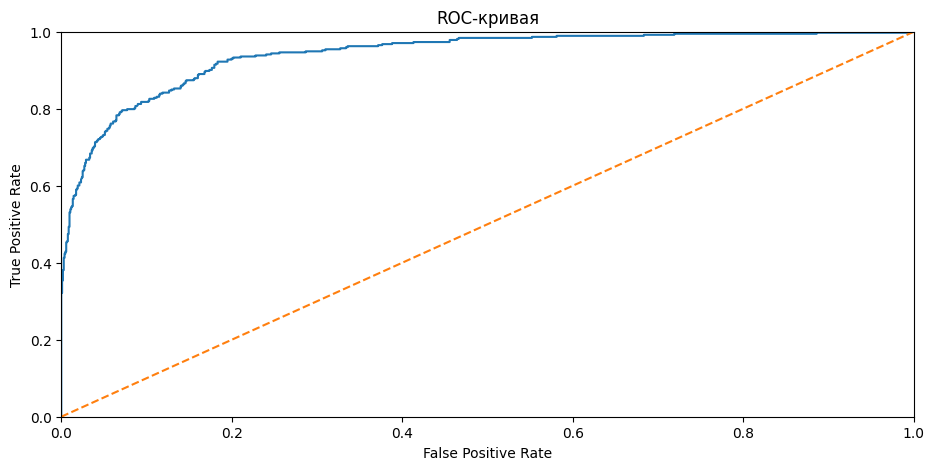

In [125]:
predected_probas = model.predict_proba(features_test)[:, 1]
plot_roc_curve(target_test, predected_probas)

# Вывод

Выведем важность признаков

In [123]:
features_relevance = pd.DataFrame(CV_CBC.best_estimator_.feature_importances_, index = features_test.columns, columns=['relevance'])
features_relevance = features_relevance.round(2).sort_values(by=['relevance'], ascending=False)
features_relevance

,relevance
TotalDays,45.73
MonthlyCharges,16.25
Type_Month-to-month,2.92
InternetService_Fiber optic,2.30
PaymentMethod_Electronic check,2.05
Type_Two year,1.87
Partner_No,1.81
PaperlessBilling_No,1.76
Dependents_No,1.72
TechSupport_No,1.59


Основным показателем является кол-во дней пользования услугами, также важными оказались месячная оплата и тип оплаты